# Set5 Dataset testing
This notebook tests the models trained for different loss functions on Set5 dataset patches and compares the outputs

## Importing the required libraries and functions for testing

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torchvision.utils import make_grid
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure as ssim
import random
from preprocess import *
from model import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Function for calculating PSNR
def calculate_psnr(img1, img2, max_pixel_value=1.0):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    psnr = 10 * torch.log10((max_pixel_value ** 2) / mse)
    return psnr

In [4]:
# Defining the directory path of the test set
test_hr_dir = "D:\Project\Datasets\classical_SR_datasets\Set5\original\HR_patches"
test_lr_dir = "D:\Project\Datasets\classical_SR_datasets\Set5\original\LR_x4_patches"

# Initializing Dataloader and loading the data
test_dataset = SRDataset(test_hr_dir, test_lr_dir, tensor_transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
# Function for visualizing a predicted image
def visualize_images(lr_img, predicted_img, hr_img, psnr_value, ssim_value, title):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # # Check if images are in the correct range [0, 1] or [0, 255]
    # if lr_img.max() > 1.0:  # Assuming images are in [0, 255]
    #     lr_img = lr_img / 255.0
    # if predicted_img.max() > 1.0:
    #     predicted_img = predicted_img / 255.0
    # if hr_img.max() > 1.0:
    #     hr_img = hr_img / 255.0
        
    # Display LR image
    axs[0].imshow(lr_img)
    axs[0].set_title('Low Resolution (LR)')
    axs[0].axis('off')

    # Display predicted image with PSNR and SSIM
    axs[1].imshow(predicted_img)
    axs[1].set_title(f'Predicted (PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f})')
    axs[1].axis('off')

    # Display HR image
    axs[2].imshow(hr_img)
    axs[2].set_title('High Resolution (HR)')
    axs[2].axis('off')

    # Add a title to the figure
    plt.suptitle(title, fontsize=16)
    plt.show()

In [6]:
# Function to convert tensor to numpy and handle HWC format for any visualizations
def tensor_to_numpy(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension if exists
    tensor = tensor.permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC
    return tensor

In [7]:
# Function to visualize predictions from multiple models for a given index
def compare_model_outputs(index, model_predictions):
    # Create a 2x4 grid for displaying LR, HR, and 6 model predictions
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # Extract LR and HR images for the given index (assuming they are shared across models)
    lr_img = model_predictions[0]['lr'][index]  # LR image from the first model (shared across all models)
    hr_img = model_predictions[0]['hr'][index]  # HR image from the first model (shared across all models)

    # Row 0, Col 0: Display LR image
    axs[0, 0].imshow(lr_img)  # Display LR image
    axs[0, 0].set_title("Low-Resolution (LR)", fontsize=18)
    axs[0, 0].axis('off')

    # Row 1, Col 0: Display HR image
    axs[1, 0].imshow(hr_img)  # Display HR image
    axs[1, 0].set_title("High-Resolution (HR)", fontsize=18)
    axs[1, 0].axis('off')

    # Loop through the model predictions and display them in the remaining grid spots
    for i, model in enumerate(model_predictions):
        row = i // 3  # Row position (either 0 or 1 for remaining predictions)
        col = (i % 3) + 1  # Column position (shifted to skip first column for LR/HR images)

        # Get predicted image and metrics for the selected index
        predicted_img = model['predicted'][index]
        psnr_value = model['psnr'][index]
        ssim_value = model['ssim'][index]

        # Display predicted image
        axs[row, col].imshow(predicted_img)
        axs[row, col].set_title(f"{model['name']} (PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f})", fontsize=16)
        axs[row, col].axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()
    # Add extra vertical space between rows
    plt.subplots_adjust(hspace=0.2)
    plt.show()

# Testing all the models on Set5 data

## 1.1 Testing MAE model

In [8]:
# Initializing the model and the best saved model parameters
model_mae = torch.load("UNet_L1_final.pth")
checkpoint = torch.load("checkpoint_L1.pt")
model_mae.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_mae.eval()

# Store results for all patches
mae_results = []

# Predict and compute metrics
with torch.no_grad():
    mae_psnr_score = 0.0
    mae_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_mae(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        mae_psnr_score += psnr_value
        mae_ssim_score += ssim_value

        # Store each result in case we need them later
        mae_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    mae_avg_psnr = mae_psnr_score / len(test_loader)
    mae_avg_ssim = mae_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {mae_avg_psnr:.4f}, Average SSIM: {mae_avg_ssim:.4f}")

C:\Users\SushanthJA\miniconda3\envs\deep_learning\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Average PSNR: 31.2283, Average SSIM: 0.8566


## 1.2 Testing MSE model

In [12]:
# Initializing the model and the best saved model parameters
model_mse = torch.load("UNet_L2_final.pth")
checkpoint = torch.load("checkpoint_L2.pt")
model_mse.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_mse.eval()

# Store results for all patches
mse_results = []

# Predict and compute metrics
with torch.no_grad():
    mse_psnr_score = 0.0
    mse_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_mse(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        mse_psnr_score += psnr_value
        mse_ssim_score += ssim_value

        # Store each result in case we need them later
        mse_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    mse_avg_psnr = mse_psnr_score / len(test_loader)
    mse_avg_ssim = mse_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {mse_avg_psnr:.4f}, Average SSIM: {mse_avg_ssim:.4f}")

Average PSNR: 31.4060, Average SSIM: 0.8576


## 1.3 Testing Tukey model

In [15]:
# Initializing the model and the best saved model parameters
model_tukey = torch.load("UNet_Tukey_c-0.3_final.pth")
checkpoint = torch.load("checkpoint_Tukey_c-0.3.pt")
model_tukey.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_tukey.eval()

# Store results for all patches
tukey_results = []

# Predict and compute metrics
with torch.no_grad():
    tukey_psnr_score = 0.0
    tukey_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_tukey(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        tukey_psnr_score += psnr_value
        tukey_ssim_score += ssim_value

        # Store each result in case we need them later
        tukey_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    tukey_avg_psnr = tukey_psnr_score / len(test_loader)
    tukey_avg_ssim = tukey_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {tukey_avg_psnr:.4f}, Average SSIM: {tukey_avg_ssim:.4f}")

Average PSNR: 31.3176, Average SSIM: 0.8590


## 1.4 Testing Charbonnier loss model

In [18]:
# Initializing the model and the best saved model parameters
model_charbonnier = torch.load("UNet_charbonnier_eps1e-4_final.pth")
checkpoint = torch.load("checkpoint_charbonnier_eps1e-4.pt")
model_charbonnier.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_charbonnier.eval()

# Store results for all patches
charbonnier_results = []

# Predict and compute metrics
with torch.no_grad():
    charbonnier_psnr_score = 0.0
    charbonnier_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_charbonnier(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        charbonnier_psnr_score += psnr_value
        charbonnier_ssim_score += ssim_value

        # Store each result in case we need them later
        charbonnier_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    charbonnier_avg_psnr = charbonnier_psnr_score / len(test_loader)
    charbonnier_avg_ssim = charbonnier_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {charbonnier_avg_psnr:.4f}, Average SSIM: {charbonnier_avg_ssim:.4f}")

Average PSNR: 31.4831, Average SSIM: 0.8605


## 1.5 Testing TV + MAE loss model

In [21]:
# Initializing the model and the best saved model parameters
model_tv_mae = torch.load("UNet_tv1e-4_mae_final.pth")
checkpoint = torch.load("checkpoint_tv1e-4_mae_final.pt")
model_tv_mae.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_tv_mae.eval()

# Store results for all patches
tv_mae_results = []

# Predict and compute metrics
with torch.no_grad():
    tv_mae_psnr_score = 0.0
    tv_mae_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_tv_mae(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        tv_mae_psnr_score += psnr_value
        tv_mae_ssim_score += ssim_value

        # Store each result in case we need them later
        tv_mae_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    tv_mae_avg_psnr = tv_mae_psnr_score / len(test_loader)
    tv_mae_avg_ssim = tv_mae_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {tv_mae_avg_psnr:.4f}, Average SSIM: {tv_mae_avg_ssim:.4f}")

Average PSNR: 31.3248, Average SSIM: 0.8569


## 1.6 Testing SSIM + MAE loss model

In [24]:
# Initializing the model and the best saved model parameters
model_ssim_mae = torch.load("UNet_L1_ssim_final.pth")
checkpoint = torch.load("checkpoint_ssim_L1.pt")
model_ssim_mae.load_state_dict(checkpoint)

# Putting the model in evaluation mode
model_ssim_mae.eval()

# Store results for all patches
ssim_mae_results = []

# Predict and compute metrics
with torch.no_grad():
    ssim_mae_psnr_score = 0.0
    ssim_mae_ssim_score = 0.0

    for i, (hr_patches, lr_patches) in enumerate(test_loader):
        hr_patches, lr_patches = hr_patches.to(device), lr_patches.to(device)

        # Predict using the model
        # with torch.cuda.amp.autocast():  # Autocast for mixed precision
        outputs = model_ssim_mae(lr_patches)

        # Calculate PSNR using PyTorch tensors
        psnr_value = calculate_psnr(outputs, hr_patches).item()

        # Calculate SSIM using torchmetrics (directly with PyTorch tensors)
        ssim_value = ssim(outputs.float(), hr_patches.float(), data_range=1.0).item()

        # Accumulate PSNR and SSIM scores
        ssim_mae_psnr_score += psnr_value
        ssim_mae_ssim_score += ssim_value

        # Store each result in case we need them later
        ssim_mae_results.append({
            "index": i,
            "lr": tensor_to_numpy(lr_patches),
            "predicted": tensor_to_numpy(outputs),
            "hr": tensor_to_numpy(hr_patches),
            "psnr": psnr_value,
            "ssim": ssim_value
        })

    # Compute average PSNR and SSIM across all test patches
    ssim_mae_avg_psnr = ssim_mae_psnr_score / len(test_loader)
    ssim_mae_avg_ssim = ssim_mae_ssim_score / len(test_loader)

    # Print or return the averages
    print(f"Average PSNR: {ssim_mae_avg_psnr:.4f}, Average SSIM: {ssim_mae_avg_ssim:.4f}")

Average PSNR: 31.4853, Average SSIM: 0.8640


# Visualizing all model predictions

In [27]:
# Adding all model predictions to a list
model_predictions = [
    {
        'name': 'MAE',
        'lr': [result['lr'] for result in mae_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in mae_results],  # Predicted images
        'hr': [result['hr'] for result in mae_results],  # HR images
        'psnr': [result['psnr'] for result in mae_results],  # PSNR values
        'ssim': [result['ssim'] for result in mae_results]  # SSIM values
    },
    {
        'name': 'MSE',
        'lr': [result['lr'] for result in mse_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in mse_results],  # Predicted images
        'hr': [result['hr'] for result in mse_results],  # HR images
        'psnr': [result['psnr'] for result in mse_results],  # PSNR values
        'ssim': [result['ssim'] for result in mse_results]  # SSIM values
    },
    {
        'name': 'Tukey',
        'lr': [result['lr'] for result in tukey_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in tukey_results],  # Predicted images
        'hr': [result['hr'] for result in tukey_results],  # HR images
        'psnr': [result['psnr'] for result in tukey_results],  # PSNR values
        'ssim': [result['ssim'] for result in tukey_results]  # SSIM values
    },
    {
        'name': 'Charbonnier',
        'lr': [result['lr'] for result in charbonnier_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in charbonnier_results],  # Predicted images
        'hr': [result['hr'] for result in charbonnier_results],  # HR images
        'psnr': [result['psnr'] for result in charbonnier_results],  # PSNR values
        'ssim': [result['ssim'] for result in charbonnier_results]  # SSIM values
    },
    {
        'name': 'TV + MAE',
        'lr': [result['lr'] for result in tv_mae_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in tv_mae_results],  # Predicted images
        'hr': [result['hr'] for result in tv_mae_results],  # HR images
        'psnr': [result['psnr'] for result in tv_mae_results],  # PSNR values
        'ssim': [result['ssim'] for result in tv_mae_results]  # SSIM values
    },
    {
        'name': 'SSIM + MAE',
        'lr': [result['lr'] for result in ssim_mae_results],  # LR image (shared across all models)
        'predicted': [result['predicted'] for result in ssim_mae_results],  # Predicted images
        'hr': [result['hr'] for result in ssim_mae_results],  # HR images
        'psnr': [result['psnr'] for result in ssim_mae_results],  # PSNR values
        'ssim': [result['ssim'] for result in ssim_mae_results]  # SSIM values
    },
]

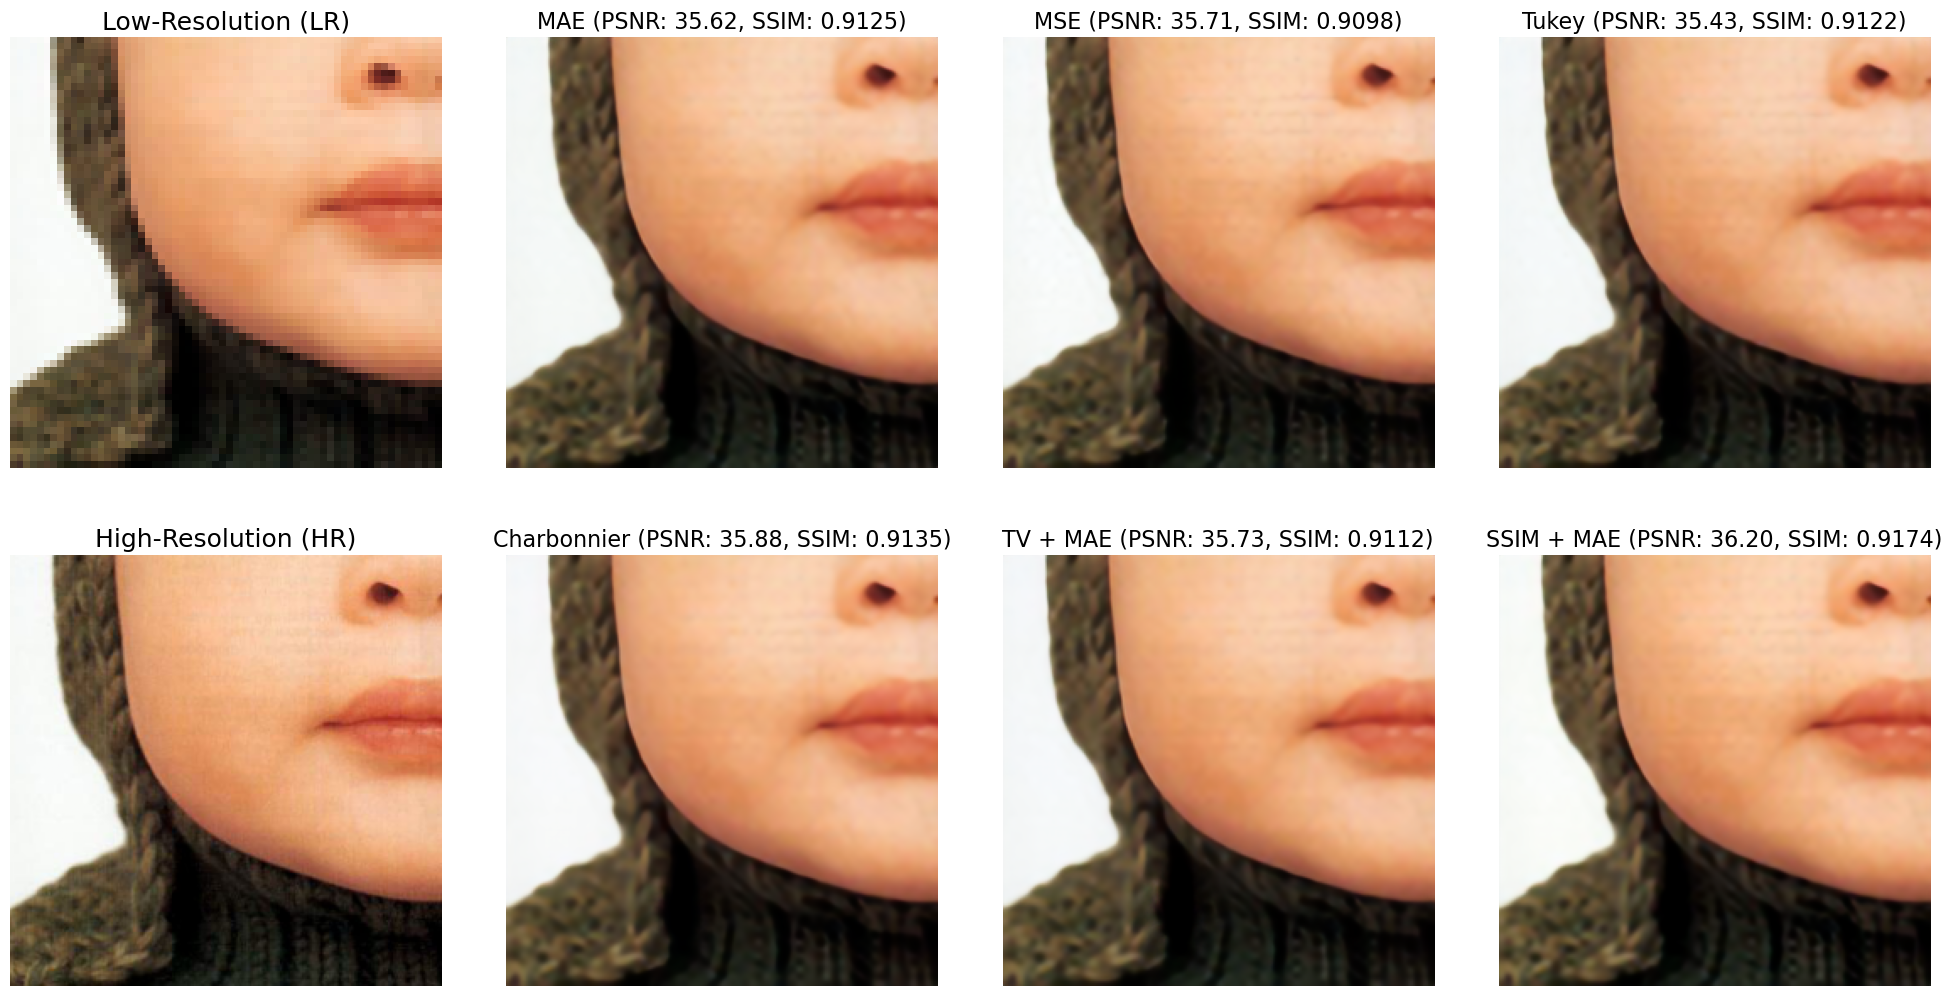

In [42]:
index = 2 # Best PSNR

# Call the function to visualize the predictions
compare_model_outputs(index, model_predictions)

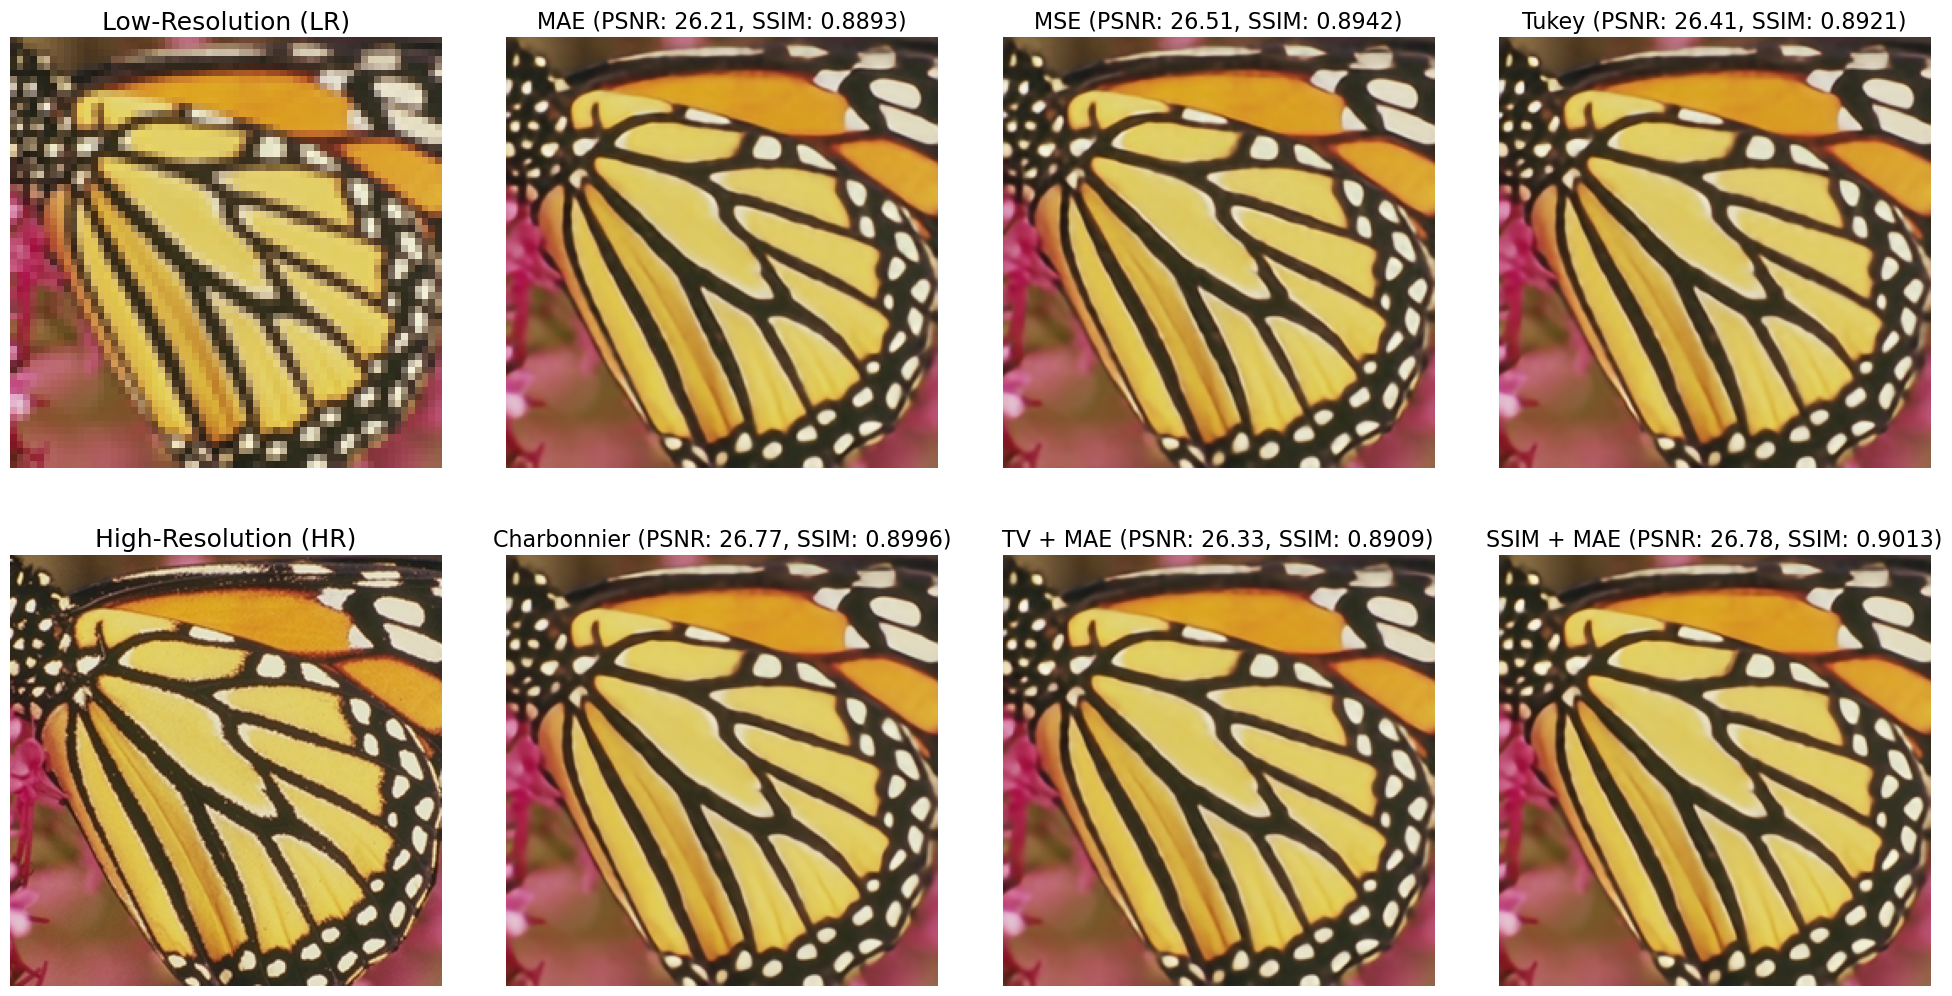

In [43]:
index = 5 # Worst PSNR

# Call the function to visualize the predictions
compare_model_outputs(index, model_predictions)

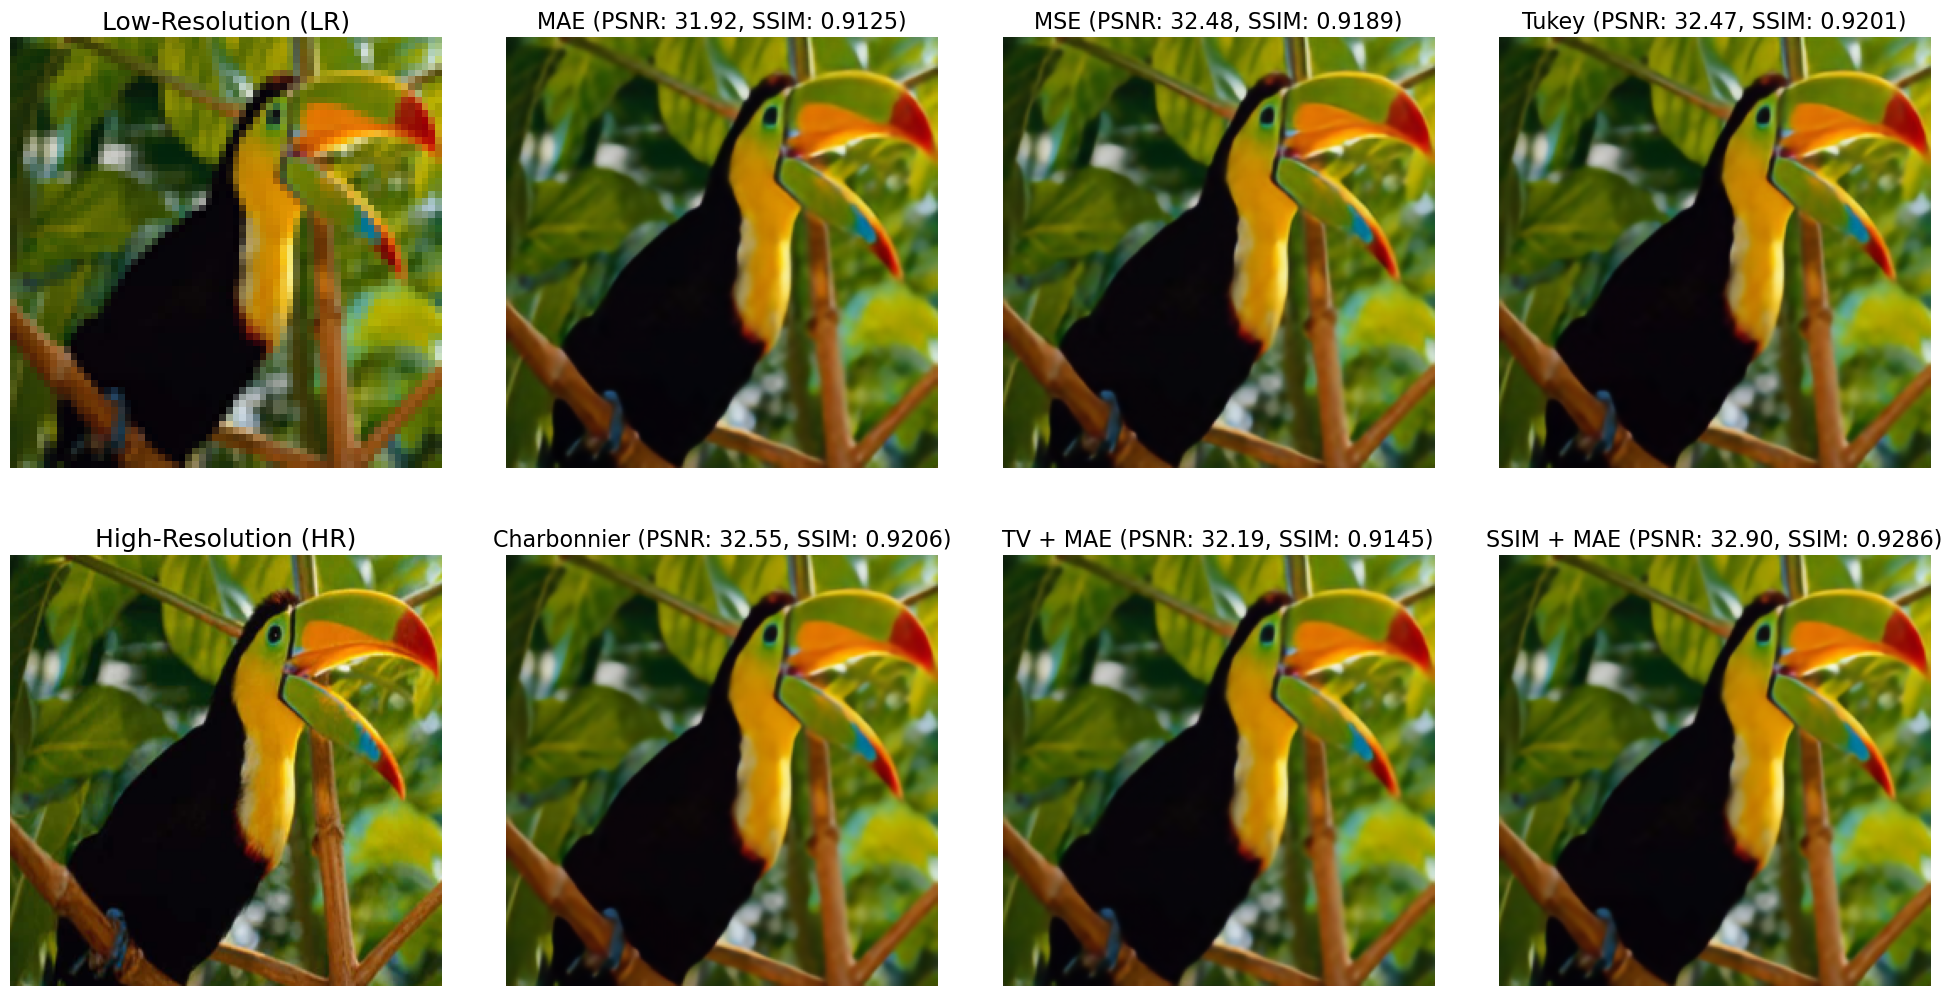

In [44]:
index = 4 # Best SSIM

# Call the function to visualize the predictions
compare_model_outputs(index, model_predictions)

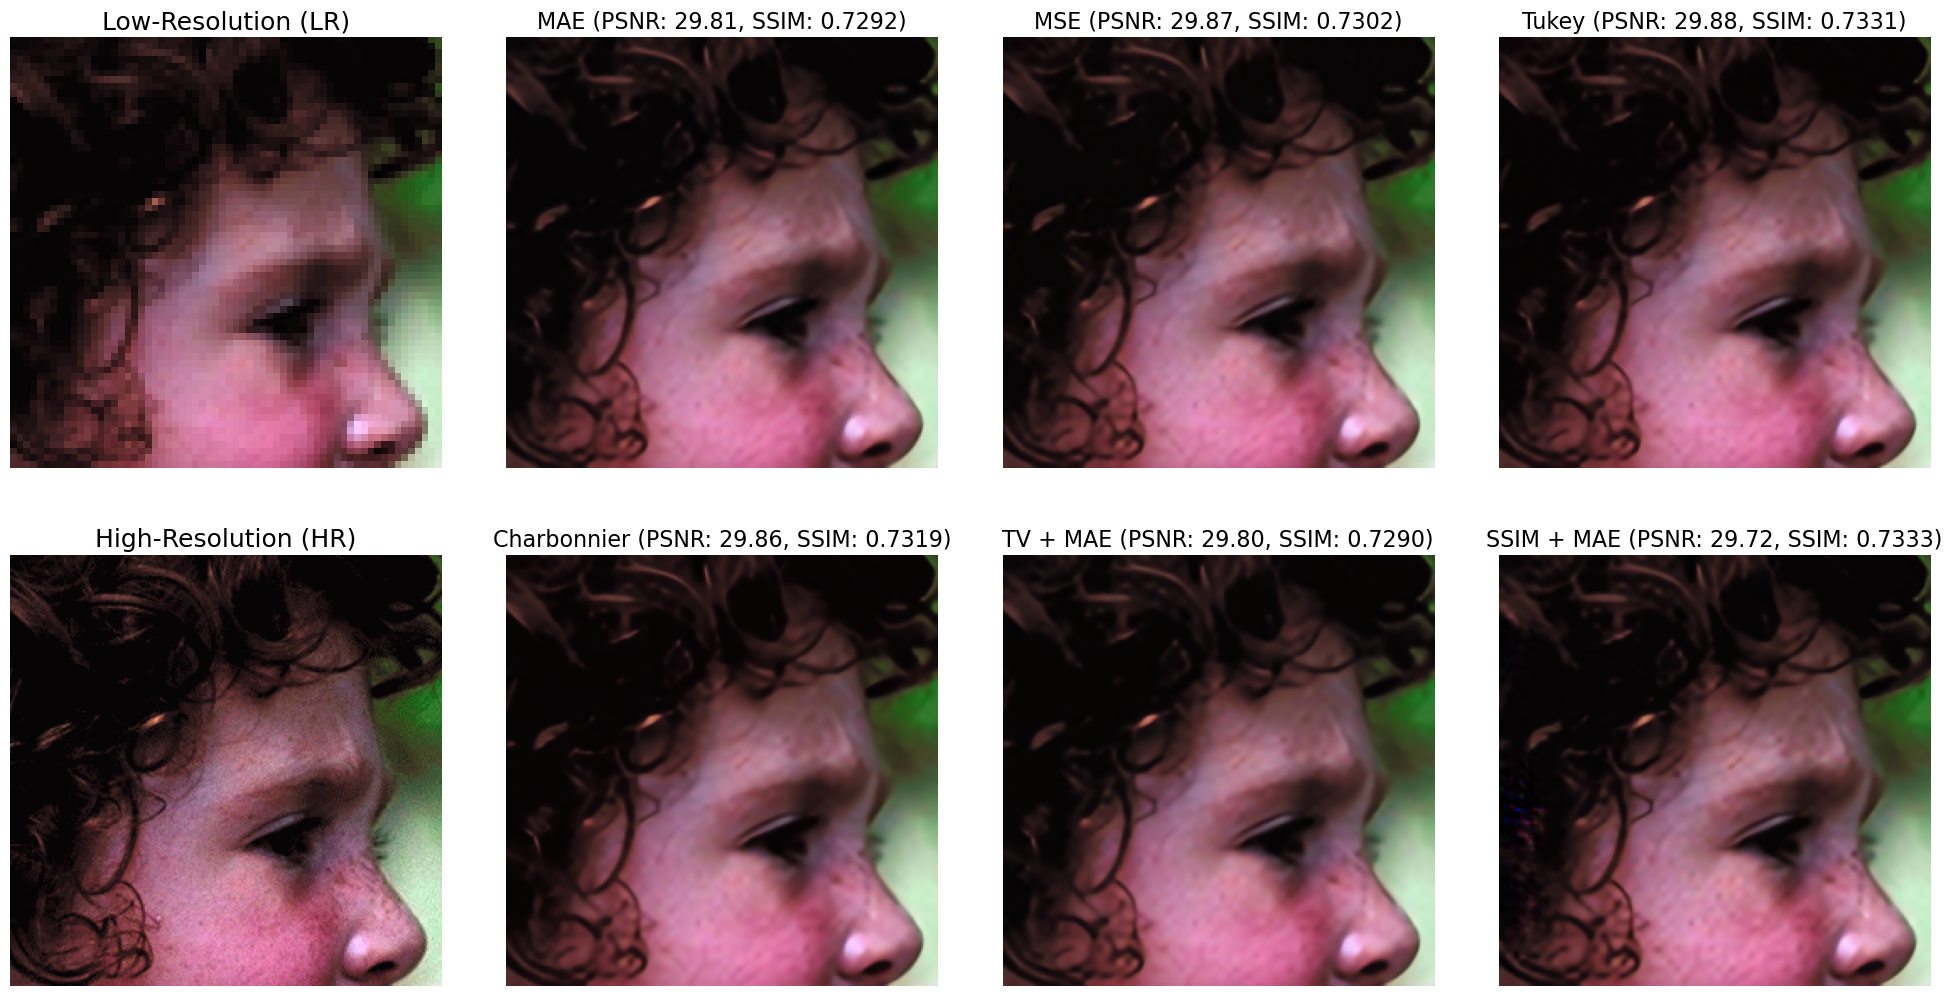

In [45]:
index = 6 # Worst SSIM

# Call the function to visualize the predictions
compare_model_outputs(index, model_predictions)

# Saving results of all models to a csv file

In [34]:
# Format for each model's result and name
models = [
    {'name': 'MAE Loss', 'results': mae_results},
    {'name': 'MSE Loss', 'results': mse_results},
    {'name': 'Tukey Loss', 'results': tukey_results},
    {'name': 'Charbonnier Loss', 'results': charbonnier_results},
    {'name': 'TV+MAE Loss', 'results': tv_mae_results},
    {'name': 'SSIM+MAE Loss', 'results': ssim_mae_results}
]

# Initialize an empty dictionary to store the results in the desired format
model_data = {}

# Loop through each model and structure the data with PSNR and SSIM as sub-columns
for model in models:
    model_name = model['name']
    results = model['results']
    
    # Create dictionaries for PSNR and SSIM for each index (patch number)
    psnr_dict = {result['index'] + 1: result['psnr'] for result in results}
    ssim_dict = {result['index'] + 1: result['ssim'] for result in results}
    
    # Add to the model_data dictionary
    model_data[f'{model_name} PSNR'] = psnr_dict
    model_data[f'{model_name} SSIM'] = ssim_dict

# Convert to a DataFrame
df = pd.DataFrame(model_data)

# Set index name as "patch_number"
df.index.name = "patch_number"

# Calculate the averages for PSNR and SSIM columns
average_row = df.mean()

# Append the averages as the last row with a label
df.loc['Average'] = average_row

# Save the DataFrame to a CSV file
df.to_csv('Set5_results.csv', index=True)

print("Combined results saved to Set5_results.csv")

Combined results saved to Set5_results.csv
